In [1]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from matplotlib import pyplot as plt
%matplotlib inline
import networkx as nx
import random
from scipy.optimize import minimize

In [2]:
class Graph:
    def __init__(self, edges_set):
        self.edges_set = edges_set
        self.node_set = []
        for i in edges_set:
            if (i.start_node not in self.node_set):
                self.node_set.append(i.start_node)
            if (i.end_node not in self.node_set):
                self.node_set.append(i.end_node) 

class Edge:
    def __init__(self, start_node, end_node, weight = 1):
        self.start_node = start_node
        self.end_node = end_node
        self.weight = weight

In [3]:
#triangle
#edge_list = [Edge(0,1,2), Edge(1,2,1), Edge(2,0,2)]
#square
#edge_list = [Edge(0,1,2), Edge(1,2,1), Edge(2,3,1), Edge(3,0,2)]
#cool graph
edge_list = [Edge(0, 1), Edge(1, 2), Edge(2, 3), Edge(3,4), Edge(4,0), Edge(1,3), Edge(2,4)]

G = nx.Graph()

for z in edge_list:
    G.add_edge(str(z.start_node), str(z.end_node))

nx.draw(G)
plt.savefig('graph.png')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [4]:
def initialize(qc):
    for q in range(qc.num_qubits):
        qc.h(q)
    

def cost_unitary(qc,gamma):
    for i in edge_list:
        qc.cu1(-2*gamma*i.weight, i.start_node, i.end_node)
        qc.u1(gamma*i.weight, i.start_node)
        qc.u1(gamma*i.weight, i.end_node)
    

def mixer_unitary(qc, beta):
    for i in range(qc.num_qubits):
        qc.rx(2*beta, i)
    


In [5]:
def create_circuit(params, num, depth=2, shots=512):

    gamma = [params[0], params[2], params[4], params[6]]
    beta = [params[1], params[3], params[5], params[7]]

    qc = QuantumCircuit(num)
    initialize(qc)
    qc.barrier()
    for i in range(0, depth):
        cost_unitary(qc, gamma[i])
        qc.barrier()
        mixer_unitary(qc, beta[i])
    qc.measure_all()

    backend = Aer.get_backend('qasm_simulator')
    results = execute(qc,backend=backend,shots=shots).result()
    #print("results :: ", results.get_counts())
    '''
    for each_key in list(results.get_counts().keys()):
        if(results.get_counts().get(each_key) > (shots/2**num)):
            results_key.append(each_key)
    '''
    
    return results.get_counts()
    

In [6]:
def cost_function(params):

    qubit_count = create_circuit(params, num, depth, shots)
    print("qubit count :: ",qubit_count)
    bit_strings = list(qubit_count.keys())
    
    total_cost = 0
    
    for bit_string in bit_strings:
        each_bs_cost = 0
        bit_string_encoding = bit_string[::-1]
        for j in edge_list:
            #multiplying the whole equation by -1 so that later minize function from scipy can be used to optimize
            each_bs_cost += -1*0.5* j.weight *( 1 -( (1 - 2*int(bit_string_encoding[j.start_node])) * (1 - 2*int(bit_string_encoding[j.end_node])) ))
        #print("bit string freq :: ", qubit_count.get(bit_string))
        total_cost += each_bs_cost*qubit_count.get(bit_string)
        
    print("Cost: "+str(total_cost/shots))

    return total_cost

In [7]:
def visualize(f):
    # Creates visualization of the optimal state
    #curently here
    nums = []
    freq = []

    for k,v in f.items():
        number = 0
        #print("key :: ",k, " values :: ",v)
        for j in range(0, len(k)):
            number += 2**(len(k)-j-1)*int(k[j])
        if (number in nums):
            freq[nums.index(number)] = freq[nums.index(number)] + v
        else:
            nums.append(number)
            freq.append(v)

    freq = [s/sum(freq) for s in freq]

    print(nums)
    print(freq)

    x = range(0, 2**num)
    y = []
    for i in range(0, len(x)):
        if (i in nums):
            y.append(freq[nums.index(i)])
        else:
            y.append(0)

    plt.bar(x, y)
    plt.show()
    
#f = {'000': 42, '001': 165, '010': 14, '011': 30, '100': 25, '101': 15, '110': 192, '111': 29}
#visualize(f)

C:\Users\Deathstroke\anaconda3\envs\qosf\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  
C:\Users\Deathstroke\anaconda3\envs\qosf\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  if __name__ == '__main__':


qubit count ::  {'00000': 9, '00001': 46, '10000': 28, '10010': 182, '10011': 9, '10100': 26, '10101': 22, '10110': 37, '10111': 9, '11000': 21, '11001': 30, '11010': 39, '11011': 19, '11101': 31, '11110': 52, '11111': 8, '00010': 34, '00011': 1, '00100': 7, '00101': 43, '00110': 25, '00111': 32, '01000': 12, '01001': 31, '01010': 31, '01011': 27, '01100': 9, '01101': 177, '01110': 1, '01111': 26}
Cost: -4.42578125
qubit count ::  {'00000': 99, '00001': 20, '10000': 26, '10001': 16, '10010': 20, '10011': 87, '10100': 26, '10101': 33, '10110': 40, '10111': 5, '11000': 27, '11001': 29, '11010': 49, '11011': 6, '11100': 13, '11101': 31, '11110': 19, '11111': 83, '00010': 29, '00011': 11, '00100': 4, '00101': 61, '00110': 30, '00111': 26, '01000': 6, '01001': 42, '01010': 24, '01011': 33, '01100': 62, '01101': 24, '01110': 14, '01111': 29}
Cost: -3.30078125
qubit count ::  {'00000': 175, '00001': 48, '10000': 24, '10001': 36, '10010': 43, '10011': 23, '10100': 12, '10101': 14, '10110': 26,

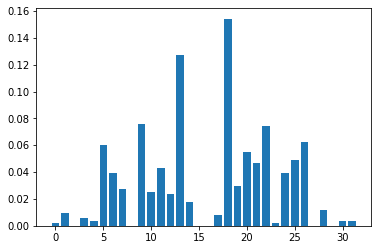

In [8]:
def do_max_cut():
    
    # Defines the optimization method
    init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
    out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':1000})
    print(out)

    optimal_params = out['x']
    f = create_circuit(optimal_params, num, depth)
    #print(f)
    visualize(f)
    
    return


shots = 1024
depth = 2
num = 5
do_max_cut()